In [1]:
%matplotlib inline

In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2021-10-01 01:24:30--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.191.44, 18.65.191.25, 18.65.191.10, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.191.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   157MB/s    in 0.3s    

2021-10-01 01:24:31 (157 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tra

  inflating: hymenoptera_data/train/ants/Nepenthes_rafflesiana_ant.jpg  
  inflating: hymenoptera_data/train/ants/swiss-army-ant.jpg  
  inflating: hymenoptera_data/train/ants/termite-vs-ant.jpg  
  inflating: hymenoptera_data/train/ants/trap-jaw-ant-insect-bg.jpg  
  inflating: hymenoptera_data/train/ants/VietnameseAntMimicSpider.jpg  
   creating: hymenoptera_data/train/bees/
  inflating: hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg  
  inflating: hymenoptera_data/train/bees/1093831624_fb5fbe2308.jpg  
  inflating: hymenoptera_data/train/bees/1097045929_1753d1c765.jpg  
  inflating: hymenoptera_data/train/bees/1232245714_f862fbe385.jpg  
  inflating: hymenoptera_data/train/bees/129236073_0985e91c7d.jpg  
  inflating: hymenoptera_data/train/bees/1295655112_7813f37d21.jpg  
  inflating: hymenoptera_data/train/bees/132511197_0b86ad0fff.jpg  
  inflating: hymenoptera_data/train/bees/132826773_dbbcb117b9.jpg  
  inflating: hymenoptera_data/train/bees/150013791_969d9a968b.jpg  
  

  inflating: hymenoptera_data/train/bees/85112639_6e860b0469.jpg  
  inflating: hymenoptera_data/train/bees/873076652_eb098dab2d.jpg  
  inflating: hymenoptera_data/train/bees/90179376_abc234e5f4.jpg  
  inflating: hymenoptera_data/train/bees/92663402_37f379e57a.jpg  
  inflating: hymenoptera_data/train/bees/95238259_98470c5b10.jpg  
  inflating: hymenoptera_data/train/bees/969455125_58c797ef17.jpg  
  inflating: hymenoptera_data/train/bees/98391118_bdb1e80cce.jpg  
   creating: hymenoptera_data/val/
   creating: hymenoptera_data/val/ants/
  inflating: hymenoptera_data/val/ants/10308379_1b6c72e180.jpg  
  inflating: hymenoptera_data/val/ants/1053149811_f62a3410d3.jpg  
  inflating: hymenoptera_data/val/ants/1073564163_225a64f170.jpg  
  inflating: hymenoptera_data/val/ants/1119630822_cd325ea21a.jpg  
  inflating: hymenoptera_data/val/ants/1124525276_816a07c17f.jpg  
  inflating: hymenoptera_data/val/ants/11381045_b352a47d8c.jpg  
  inflating: hymenoptera_data/val/ants/119785936_dd428e4

  inflating: hymenoptera_data/val/bees/65038344_52a45d090d.jpg  
  inflating: hymenoptera_data/val/bees/6a00d8341c630a53ef00e553d0beb18834-800wi.jpg  
  inflating: hymenoptera_data/val/bees/72100438_73de9f17af.jpg  
  inflating: hymenoptera_data/val/bees/759745145_e8bc776ec8.jpg  
  inflating: hymenoptera_data/val/bees/936182217_c4caa5222d.jpg  
  inflating: hymenoptera_data/val/bees/abeja.jpg  



Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualize a few images  
Let's visualize a few training images so as to understand the data
augmentations.



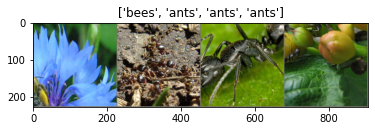

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

Generic function to display predictions for a few images




In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /workspace/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5512 Acc: 0.7254
val Loss: 0.2065 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4743 Acc: 0.8074
val Loss: 0.5330 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.5833 Acc: 0.7582
val Loss: 0.2303 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5652 Acc: 0.7828
val Loss: 0.5565 Acc: 0.7974

Epoch 4/24
----------
train Loss: 0.4637 Acc: 0.8320
val Loss: 0.4325 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.8040 Acc: 0.7213
val Loss: 0.6903 Acc: 0.8105

Epoch 6/24
----------
train Loss: 0.4579 Acc: 0.8074
val Loss: 0.4639 Acc: 0.8301

Epoch 7/24
----------
train Loss: 0.3831 Acc: 0.8648
val Loss: 0.2447 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3578 Acc: 0.8238
val Loss: 0.2334 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3258 Acc: 0.8566
val Loss: 0.2494 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3093 Acc: 0.8566
val Loss: 0.2091 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3287 Acc: 0.8607
val Loss: 0.1994 Acc: 0.9216

Epoch 12/24
----------
t

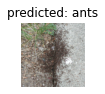

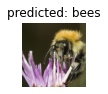

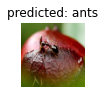

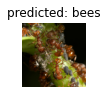

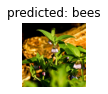

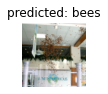

In [16]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5716 Acc: 0.6926
val Loss: 0.2025 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5344 Acc: 0.7336
val Loss: 0.2056 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3570 Acc: 0.8402
val Loss: 0.1832 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4776 Acc: 0.7910
val Loss: 0.1954 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.3999 Acc: 0.8115
val Loss: 0.3182 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.5577 Acc: 0.7869
val Loss: 0.1950 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4337 Acc: 0.8238
val Loss: 0.2270 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4651 Acc: 0.7664
val Loss: 0.1966 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3557 Acc: 0.8607
val Loss: 0.1897 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3187 Acc: 0.8443
val Loss: 0.2122 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3043 Acc: 0.8975
val Loss: 0.1961 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3669 Acc: 0.8443
val Loss: 0.2000 Acc: 0.9281

Ep

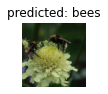

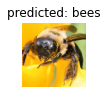

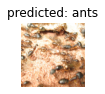

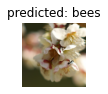

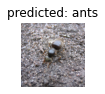

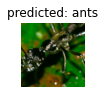

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##### Copyright 2021 PyTorch.